In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import shap
import time

import sys
sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import FunctionCollection as fc
fc = importlib.reload(fc)
import os
import sqlite3
import torch
import captum.attr as c

In [2]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'OscNext_Angle_m27_2xPvM'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 4,
        'N_metalayers': 2,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': 'sylf',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'output_offset': [3.14,1.57],
        'lr': 0.0209,
        'filename': 'dev_lvl7_mu_nu_e_classification_v003_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'event_no, azimuth, zenith, azimuth_retro, zenith_retro, azimuth_sigma, zenith_sigma, energy_log10, pid, elasticity',
        'TrTV': (0,1,1)
       }

In [3]:
event_nos = pd.read_csv('samples/explain_event_nos.csv')

In [10]:
event_nos.__len__()

165840

In [4]:
filepath = os.path.join(path,'raw_data')

centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'width': [4.5],
                        'rqe': [1.175]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300],
                        'width': [3.5],
                        'rqe': [0.175]})

centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
                               event_nos = event_nos.values[:,-1],
                               x_transform = x_transform,
                               y_transform = y_transform,
                               shuffle = False)

In [176]:
device = torch.device('cuda')

import Model_Loaders.Model_27 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
model.eval();
model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [177]:
e = c.ShapleyValueSampling(model)

In [213]:
truths = []
svs = []

In [214]:
for i in range(5):
    data = dataset[i]
    
    sv = e.attribute(torch.cat([data.x.unsqueeze(0).to(device) for i in range(4)],dim=0),
                     n_samples=10,
                     target = torch.tensor([0,1,2,3]).to(device),
                     perturbations_per_eval=1024).squeeze().cpu().numpy()
    
    svs.append(np.concatenate([(np.ones(data.x.shape[0])*data.y[:,0].item()).reshape(-1,1),
                np.concatenate([sv[i] for i in range(4)],axis=1)],axis=1))
    
    output = model(data.x.to(device)).cpu().detach()
    output[:,:2] += torch.tensor(args['output_offset'])
    output[:,2:] = output[:,2:]**2 + args['eps']
    truth = np.concatenate([data.y.numpy(),output.numpy()],axis=1)

    truths.append(truth)


In [215]:
svs = np.concatenate(svs,axis=0)
truths = np.concatenate(truths,axis=0)

# df_svs = pd.DataFrame(svs)

In [216]:
svs.shape, truths.shape

((141, 29), (5, 14))

In [220]:
svs_column_names = ['event_no']
svs_column_names += ['az_'+feat for feat in args['features'].split(', ')]
svs_column_names += ['ze_'+feat for feat in args['features'].split(', ')]
svs_column_names += ['azk_'+feat for feat in args['features'].split(', ')]
svs_column_names += ['zek_'+feat for feat in args['features'].split(', ')]

truths_column_names = args['targets'].split(', ')
truths_column_names += ['azimuth_pred','zenith_pred','azimuth_k','zenith_k']

In [223]:
df_svs = pd.DataFrame(svs,columns=svs_column_names)
df_truths = pd.DataFrame(truths,columns=truths_column_names)

In [224]:
df_truths

,event_no,azimuth,zenith,azimuth_retro,zenith_retro,azimuth_sigma,zenith_sigma,energy_log10,pid,elasticity,azimuth_pred,zenith_pred,azimuth_k,zenith_k
0,3560219.0,4.534080,2.635602,1.018231,2.306293,1.207016,0.609026,1.003891,14.0,-1.000000,6.031946,2.462022,1.039310,11.190619
1,232095.0,5.755915,2.068573,5.306581,1.955461,0.482195,0.450288,1.062459,-14.0,0.008818,5.453363,2.296921,1.451067,9.304886
2,7384368.0,0.711277,1.747545,5.265240,2.271018,0.767068,0.724109,0.772455,-12.0,0.347926,6.368277,2.310105,0.284086,5.057458
3,3594958.0,0.611572,0.562104,1.475412,0.630542,0.495096,0.200534,1.999565,14.0,0.899437,1.587039,0.530353,2.649650,16.274277
4,7357435.0,2.153621,2.820359,1.506014,2.751485,0.724935,0.127259,1.084061,12.0,0.035520,3.125886,2.563389,0.809950,17.292622


In [131]:
sv = e.attribute(torch.cat([data.x.unsqueeze(0) for i in range(4)],dim=0),
                 n_samples=10,
                 target = torch.tensor([0,1,2,3]).to(device),
                 perturbations_per_eval=1024).squeeze().cpu().numpy()

torch.Size([72, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])
torch.Size([9072, 7])


(array([ 3.,  2.,  6.,  5., 17., 18., 12., 12., 13., 12.]),
 array([-0.76519436, -0.76519389, -0.76519341, -0.76519294, -0.76519247,
        -0.765192  , -0.76519153, -0.76519106, -0.76519059, -0.76519012,
        -0.76518965]),
 <a list of 10 Patch objects>)

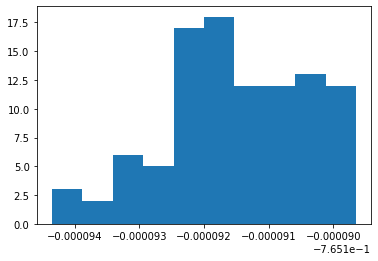

In [127]:
i,j = 3,-3
fig, ax = plt.subplots()
ax.hist(ouputs[:,i,j].cpu(),bins=10)

In [83]:
sv = e.attribute(data.x.unsqueeze(0),
                 n_samples=1000,
                 target = 0,
                 perturbations_per_eval=1024*8).squeeze().cpu().numpy()

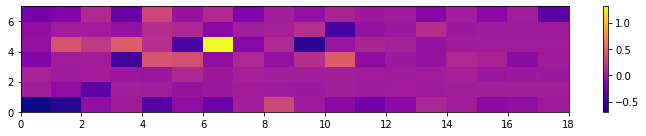

In [82]:
plot_shapvals(sv)

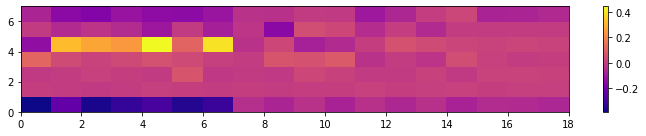

In [84]:
plot_shapvals(sv)

In [55]:
data.x.requires_grad = True
output = model(data.x)

In [59]:
outputs = []
for i in range(100):
    output = model(data.x)
    outputs.append(torch.autograd.grad(output[0,0],data.x))

In [63]:
ouputs=torch.cat([outputs[i][0].unsqueeze(0) for i in range(100)],dim=0)

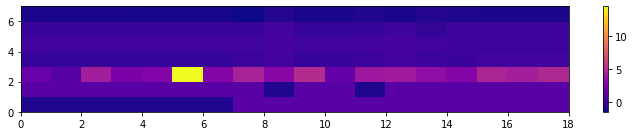

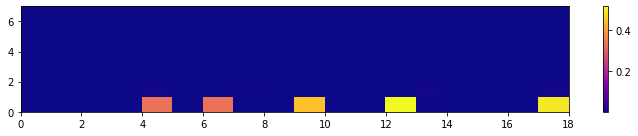

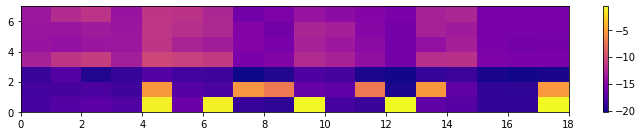

In [74]:
ouputs.shape
plot_shapvals(data.x.cpu().detach())
plot_shapvals(ouputs.std(0).cpu())
plot_shapvals(np.log(ouputs.std(0).cpu()))

In [6]:
e = c.IntegratedGradients(model)

In [7]:
data = dataset[0].to(device)
data

Data(x=[18, 7], y=[1, 10])

In [33]:
torch.cat([torch.tensor([[0,0,0,0,0,0,-1]]) for _ in range(data.x.shape[0])],dim=0).unsqueeze(0).shape

torch.Size([1, 18, 7])

In [35]:
ig = e.attribute(inputs=data.x.unsqueeze(0),
                baselines = torch.cat([torch.tensor([[0,0,0,0,0,0,-1]]) for _ in range(data.x.shape[0])],dim=0).unsqueeze(0).to(device),
                target = 0,
                n_steps = 100).squeeze().cpu().numpy()

In [13]:
def plot_shapvals(shapvals):
    fig, ax = plt.subplots(figsize=(10,2))
    im = ax.pcolor(shapvals.T,cmap='plasma')
    fig.colorbar(im)
    fig.tight_layout()

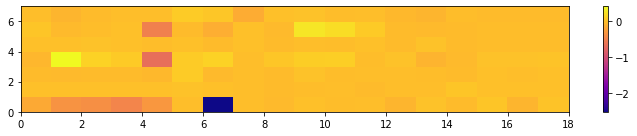

In [36]:
plot_shapvals(ig)

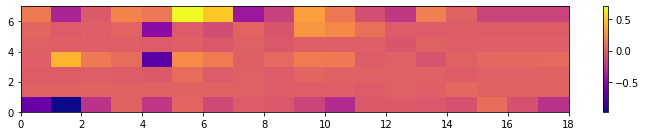

In [35]:
plot_shapvals(ig)

In [9]:
N=100

np.zeros((N,*data.x.shape)).shape

(100, 18, 7)

In [10]:
ig = e.attribute(inputs=torch.cat([data.x.unsqueeze(0) for _ in range(N)],dim=0),
            baselines = 0,
            target = 0,
            internal_batch_size = 1024*4,
            n_steps = 100).squeeze().cpu().numpy()

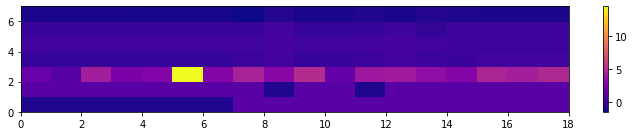

In [24]:
plot_shapvals(data.x.cpu())

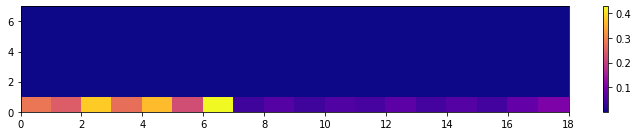

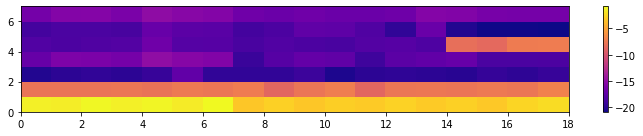

In [16]:
plot_shapvals(ig.std(0))
plot_shapvals(np.log(ig.std(0)))

In [26]:
background = dataset.collate(dataset[[i for i in range(5000)]])

In [ ]:
torch.tensor([0,0,0,0,0,0,-1])

In [29]:
background.x.mean(0), background.x.std(0)

(tensor([-0.2907,  0.5490,  3.7867, -0.1420,  0.1596, -0.1195, -1.1700],
        dtype=torch.float64),
 tensor([0.9568, 0.8358, 4.1606, 0.2040, 0.1793, 0.1981, 0.2722],
        dtype=torch.float64))